## MODÉLISATION DU RISQUE DE CRÉDIT
# Modèle de scoring


In [144]:
# Import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

----------INFO----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None
-

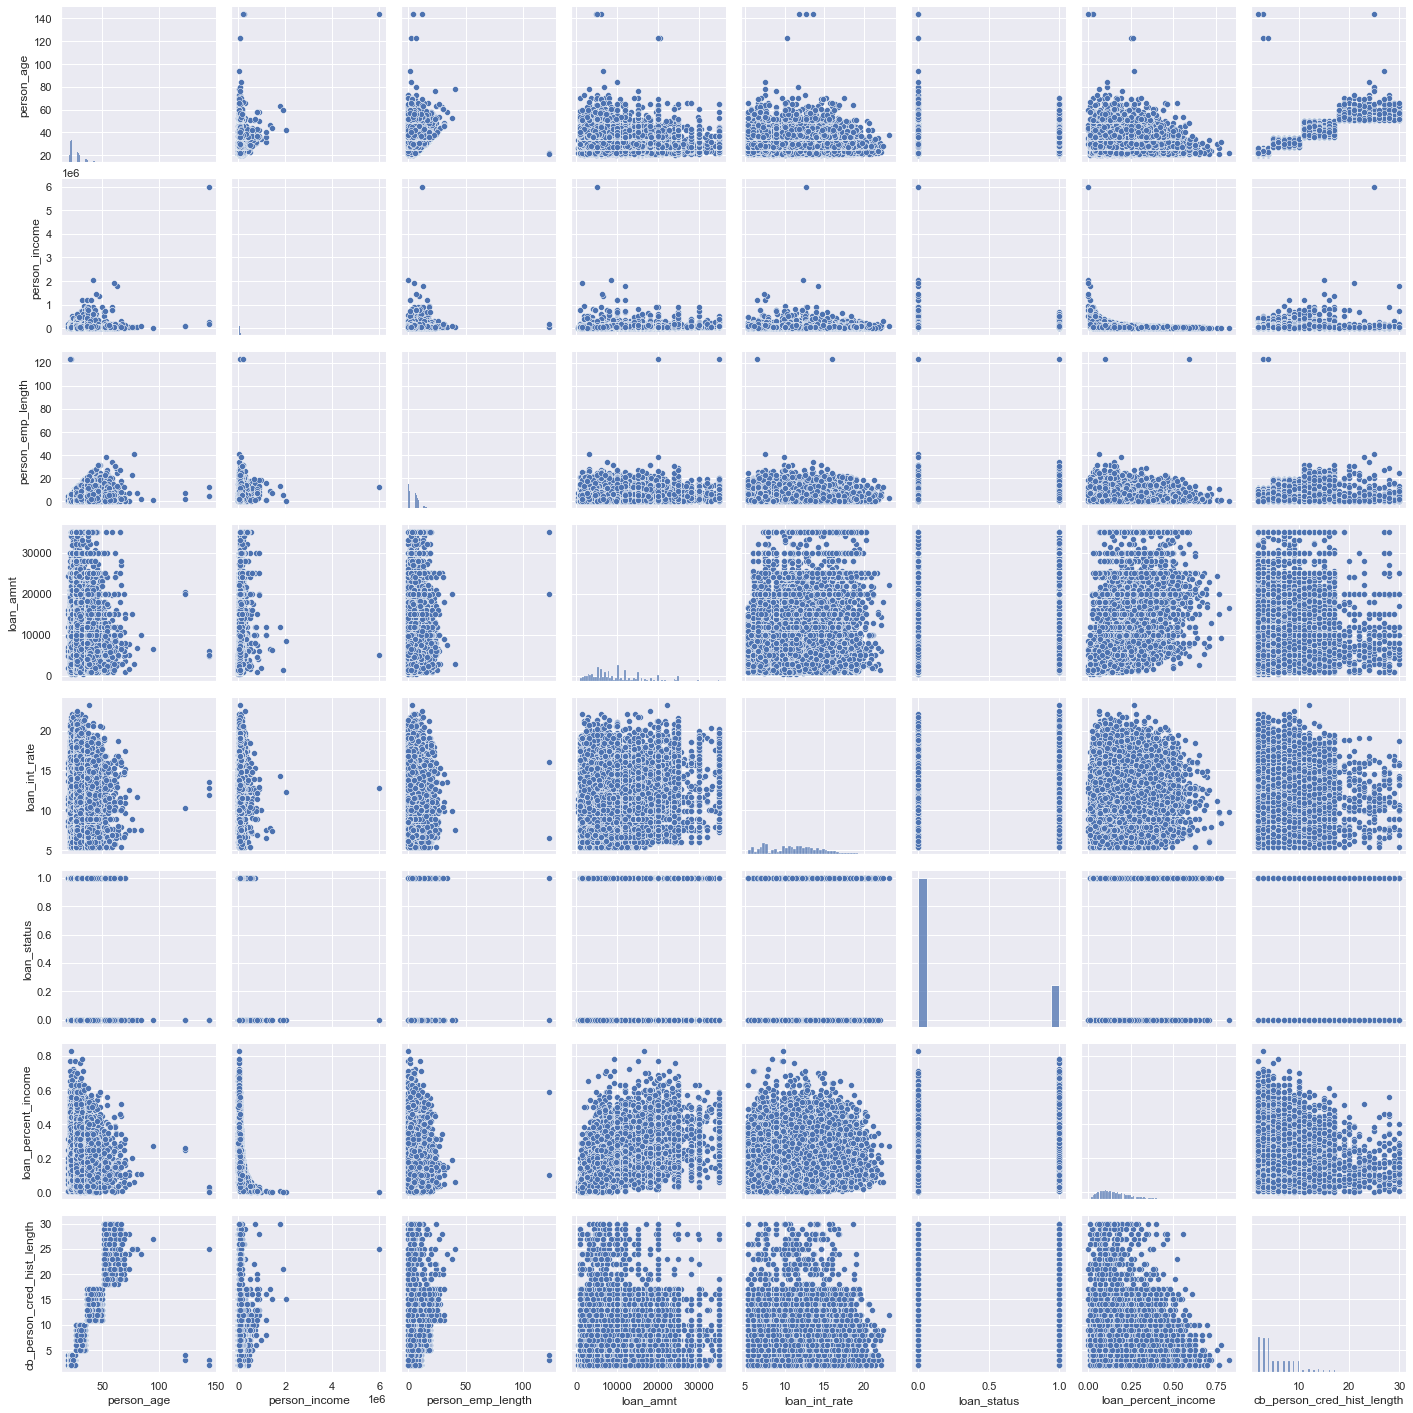

----------distplot----------


c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


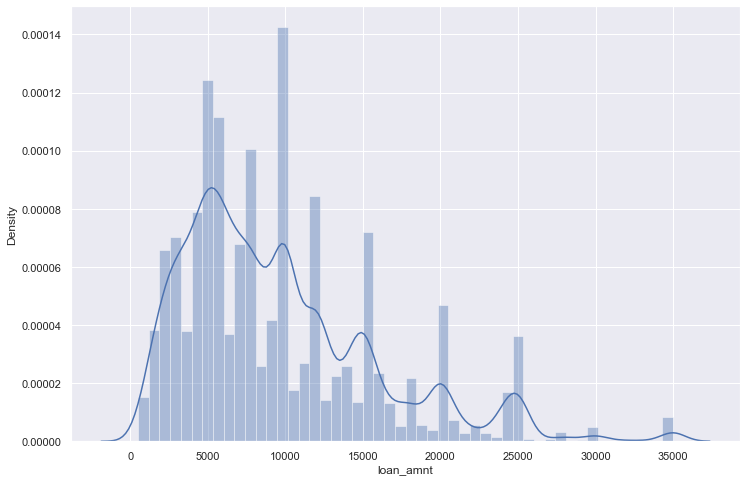

In [145]:
from matplotlib.pyplot import rc


df = pd.read_csv("https://github.com/JosueAfouda/Credit-Risk-Modeling/raw/master/data_credit.txt")
# df.head()
print("----------INFO----------")
print(df.info())
print("----------DESCRIBE----------")
print(df.describe())
print("----------pairplot----------")
sns.pairplot(df)
plt.show()
print("----------distplot----------")
sns.set_theme(rc={'figure.figsize': (12,8)})
sns.distplot(df['loan_amnt'])  #TODO : found what's equivalent 
plt.show()

In [146]:
df.skew()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18000\1665899112.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


person_age                     2.581393
person_income                 32.865349
person_emp_length              2.614455
loan_amnt                      1.192477
loan_int_rate                  0.208550
loan_status                    1.364888
loan_percent_income            1.064669
cb_person_cred_hist_length     1.661790
dtype: float64

In [147]:
df['person_income'] = np.log(df['person_income']) # Log transfo
df['person_income'].skew() # asymetric coeff of transformed var (log)

0.1559408016162584

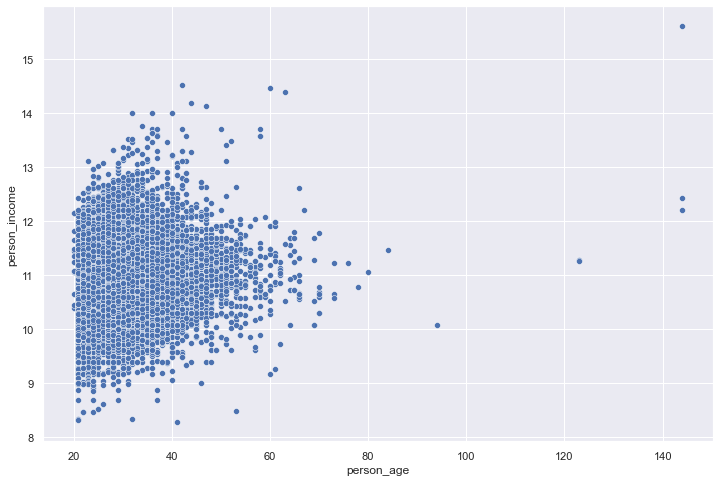

In [148]:
sns.set_theme(rc={"figure.figsize": (12,8)})
sns.scatterplot(x='person_age', y="person_income", data=df)
plt.show()

c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


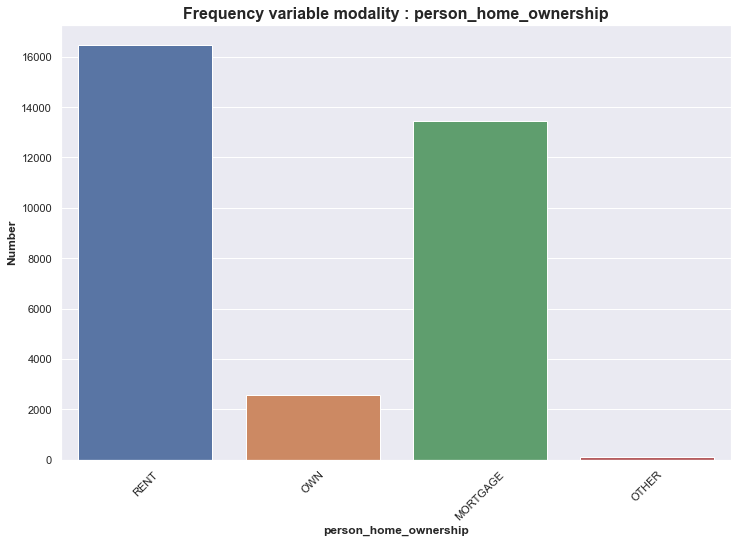

c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


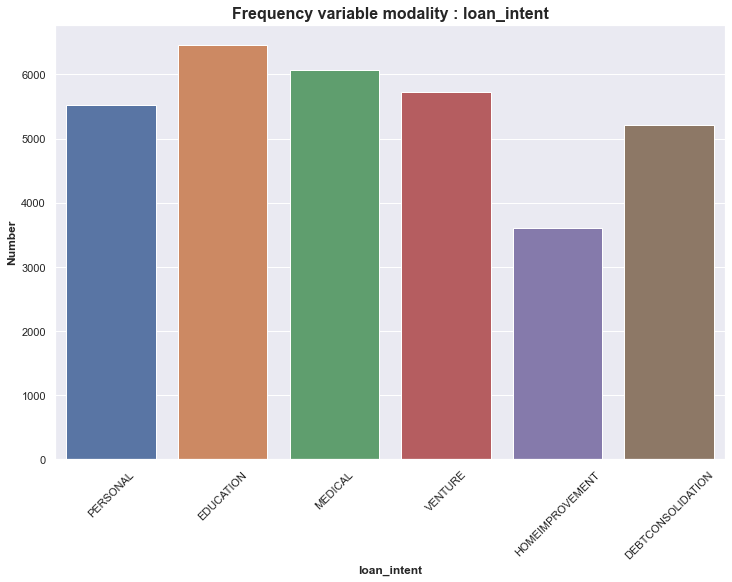

c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


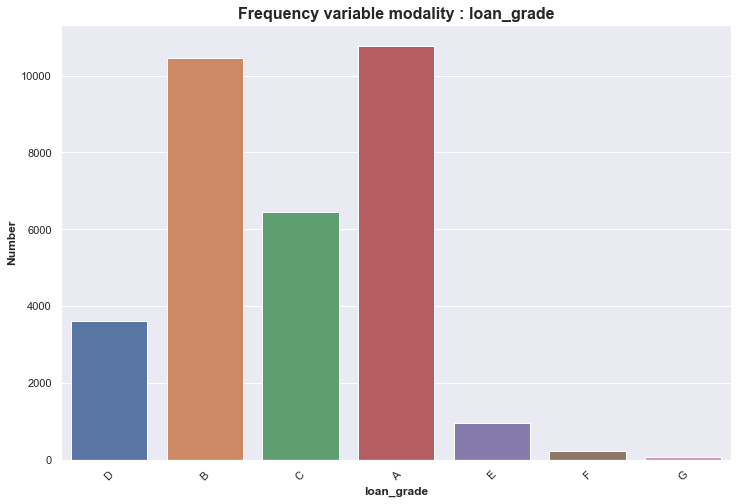

c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


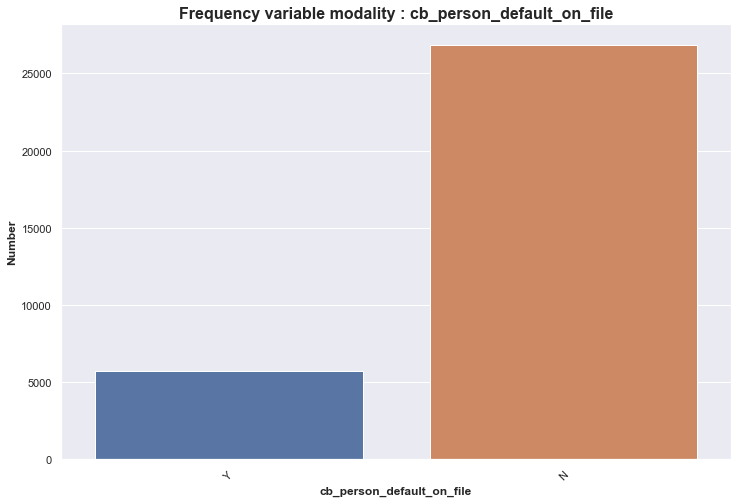

c:\Users\Admin\AppData\Local\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


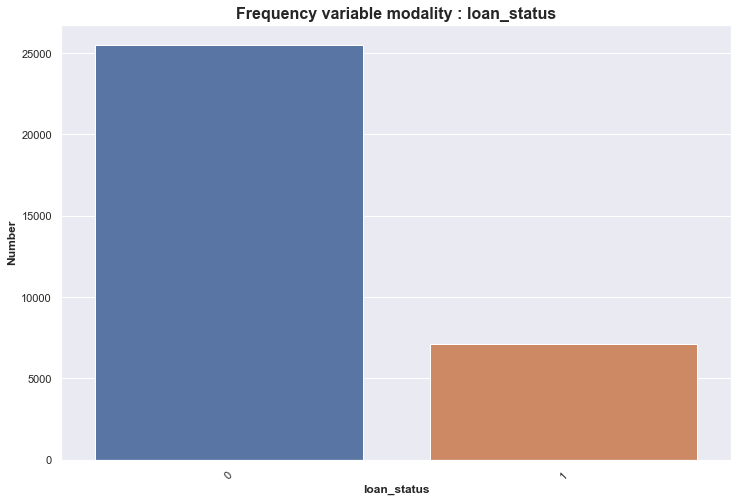

In [149]:
for column in df.select_dtypes(include=['object']).columns.to_list() + ['loan_status']:
    sns.countplot(df[column])
    plt.xlabel(column, fontweight="bold")
    plt.ylabel("Number", fontweight="bold")
    plt.xticks(rotation=45)

    plt.title(f"Frequency variable modality : {str(column)}", fontsize=16, fontweight="bold")
    plt.show()
    print()

In [150]:
pd.crosstab(df["loan_intent"], df["loan_status"], margins=True) # Cross Dynamic table

loan_status,0,1,All
loan_intent,,,
DEBTCONSOLIDATION,3722,1490,5212
EDUCATION,5342,1111,6453
HOMEIMPROVEMENT,2664,941,3605
MEDICAL,4450,1621,6071
PERSONAL,4423,1098,5521
VENTURE,4872,847,5719
All,25473,7108,32581


In [151]:
pd.crosstab(df["person_home_ownership"], [df["loan_status"], df["loan_grade"]])

loan_status               0                                 1             \
loan_grade                A     B     C    D    E   F  G    A     B    C   
person_home_ownership                                                      
MORTGAGE               5219  3729  1934  658  178  36  0  239   324  321   
OTHER                    23    29    11    9    2   0  0    3     5    6   
OWN                     860   770   464  264   26   7  0   66    34   31   
RENT                   3602  4222  2710  554  137  28  1  765  1338  981   

loan_status                               
loan_grade                D    E   F   G  
person_home_ownership                     
MORTGAGE                553  161  61  31  
OTHER                    11    6   2   0  
OWN                      18   31   8   5  
RENT                   1559  423  99  27

In [152]:
pd.crosstab(df["person_home_ownership"], df["loan_status"], values=df["loan_percent_income"], aggfunc="mean")

loan_status,0,1
person_home_ownership,,
MORTGAGE,0.146504,0.184882
OTHER,0.143784,0.300000
OWN,0.180013,0.297358
RENT,0.144611,0.264859


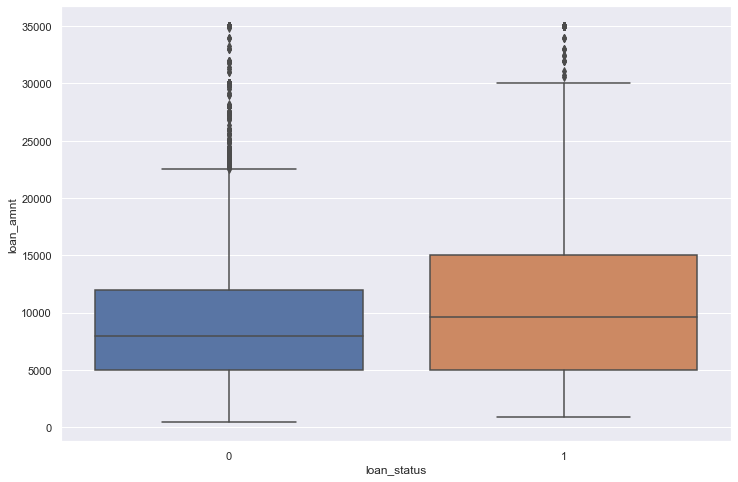

In [153]:
# loan _amnt vs loan_status
sns.boxplot(x="loan_status", y="loan_amnt", data=df)
plt.show()

<AxesSubplot:xlabel='loan_grade', ylabel='loan_int_rate'>

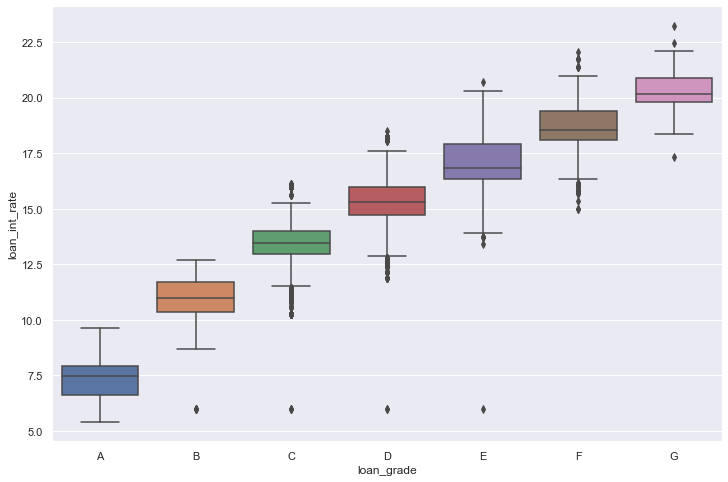

In [154]:
# loan int rate vs loan_grade
credit_grade = ["A", "B", "C", "D", "E", "F", "G"]
sns.set_theme(rc={'figure.figsize': (12,8)})
sns.boxplot(x="loan_grade", y="loan_int_rate", data=df, order=credit_grade)


<AxesSubplot:xlabel='loan_grade', ylabel='loan_int_rate'>

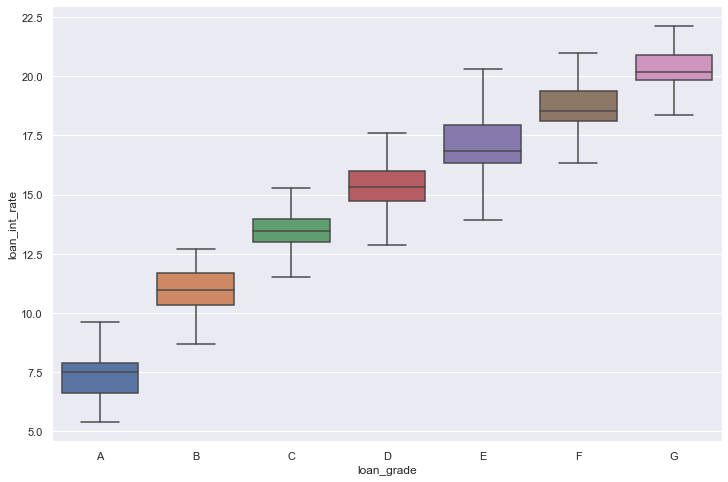

In [155]:
# same graph without outliers
sns.set_theme(rc={'figure.figsize': (12,8)})
sns.boxplot(x="loan_grade", y="loan_int_rate", data=df, order=credit_grade, sym="")

Text(0.5, 1.0, 'Correlation Map')

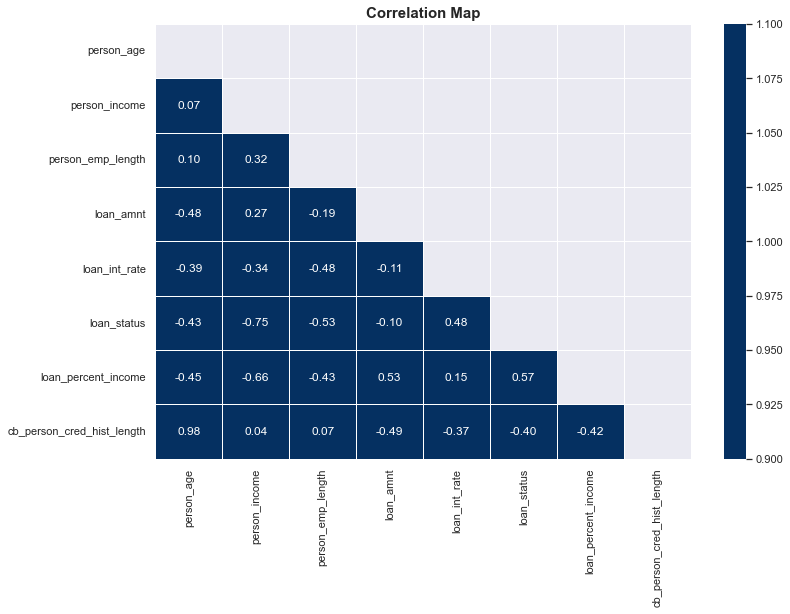

In [156]:
# Correlation Map
mask = np.triu(np.ones_like(df.select_dtypes(exclude=['object']).corr(), dtype=bool))

sns.heatmap(df.select_dtypes(exclude=['object']).corr().corr(), mask=mask, center=0, cmap="RdBu", linewidths=1, annot=True, fmt=".2f", vmin=1, vmax=1)
plt.title("Correlation Map", fontsize=15, fontweight="bold")

In [157]:
# Outliers detection
def detection_outliers_by_iqr(y):
    Q1, Q3 = np.quantile(y, 0.25), np.quantile(y, 0.75)
    iqr = Q3 - Q1 # is the minus 
    borne_i = Q1 - (iqr * 1.5)
    borne_m = Q3 + (iqr * 1.5) # is not minus 
    return np.where((y > borne_m) | (y < borne_i))

indices_outliers_age = detection_outliers_by_iqr(df['person_age'])
print(indices_outliers_age)
print(type(indices_outliers_age))

(array([   81,   183,   575, ..., 32578, 32579, 32580], dtype=int64),)
<class 'tuple'>


In [158]:
df.drop(indices_outliers_age[0], inplace=True) # The numpy table was the first element of tuple
df.shape
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              861
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 2953
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [159]:
# Two principale technique to treat empty values
# - Delete the lines contains empty values
# - replace the empty data with imputation by average , median, ...etc of the variable with empty values. 
# You can also use other method like the nearest K. (KNN)

# Imputation by median
# person_emp_length = df["person_emp_length"]
df["person_emp_length"] = df["person_emp_length"].fillna(df["person_emp_length"].median())

# loan_int_rate = df["loan_int_rate"]
df["loan_int_rate"] = df["loan_int_rate"].fillna(df["loan_int_rate"].median())
# Check result 

print(df.isna().sum())

# # Imputation by mean
# df["person_emp_length"] = person_emp_length.fillna(person_emp_length.mean())
# df["loan_int_rate"] = loan_int_rate.fillna(loan_int_rate.mean())
# # Check result 
# print(df.isna().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [160]:
# Df numeric
vars_num = df.select_dtypes(exclude=['object'])
# Df no numeric
vars_cat = df.select_dtypes(include=['object'])

# transform no numeric variable
vars_cat_dummies  =pd.get_dummies(vars_cat)

new_df = pd.concat([vars_num, vars_cat_dummies], axis=1)

new_df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,22,10.985293,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9.169518,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9.169518,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,11.089805,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,10.904119,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1


In [161]:
# trains / test data
X = new_df.drop("loan_status" , axis=1) # x is new independant datafram
y = new_df['loan_status'] # Y is dependant ( interest variable )

SEED = 123

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=SEED)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21760, 26)
(9327, 26)
(21760,)
(9327,)


In [163]:
# Model creation
rf = RandomForestClassifier(random_state=SEED)

# Train
rf.fit(X_train, y_train)

# global precision
print(f"Scoring from train data: {rf.score(X_train, y_train)}")
print(f"Scoring from test data: {rf.score(X_test, y_test)}")

Scoring from train data: 0.9999540441176471
Scoring from test data: 0.9356706336442586


In [164]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.73      0.83      2037

    accuracy                           0.94      9327
   macro avg       0.95      0.86      0.90      9327
weighted avg       0.94      0.94      0.93      9327



In [166]:
# importance var
vars_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(vars_imp)

loan_percent_income               0.227448
person_income                     0.143809
loan_int_rate                     0.109570
loan_amnt                         0.076076
person_emp_length                 0.060354
person_home_ownership_RENT        0.050525
loan_grade_D                      0.048754
person_age                        0.044365
cb_person_cred_hist_length        0.034412
person_home_ownership_MORTGAGE    0.028716
loan_intent_DEBTCONSOLIDATION     0.023212
loan_intent_MEDICAL               0.022241
loan_grade_C                      0.019900
person_home_ownership_OWN         0.018639
loan_intent_HOMEIMPROVEMENT       0.014150
loan_grade_E                      0.011795
loan_grade_A                      0.010900
loan_intent_EDUCATION             0.010697
loan_intent_PERSONAL              0.008946
loan_intent_VENTURE               0.008513
cb_person_default_on_file_N       0.007469
cb_person_default_on_file_Y       0.006634
loan_grade_B                      0.005134
loan_grade_

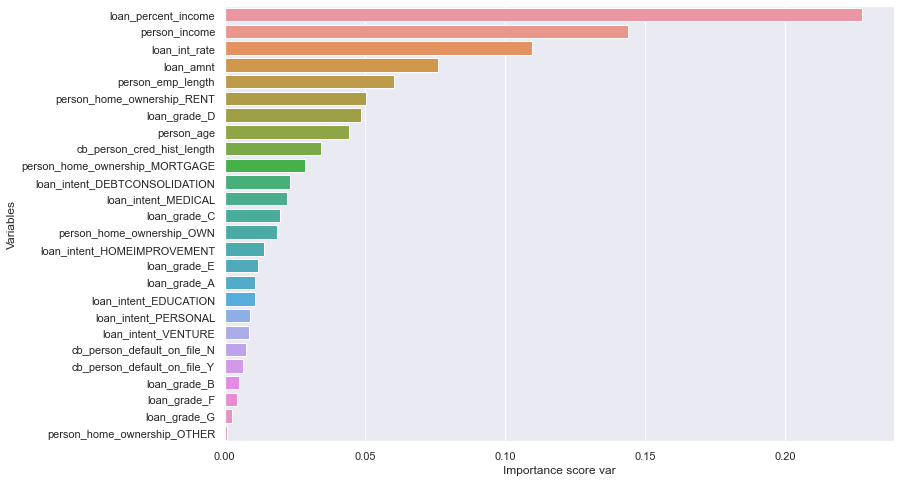

In [167]:
# importance var exploration
sns.barplot(x=vars_imp, y=vars_imp.index)
plt.xlabel("Importance score var")
plt.ylabel("Variables")
plt.title=("importance var predict")
plt.show()

In [175]:
# after this we choose to rebuild Forest Model

vars_selected = vars_imp[vars_imp > 0.010].index.to_list()
# print(vars_selected)

X_train, X_test, y_train, y_test = train_test_split(X[vars_selected], y, stratify=y, test_size=0.3, random_state=SEED)
print("----- x train")
print(X_train.shape)
print("----- x test")
print(X_test.shape)
print("----- y train")
print(y_train.shape)
print("----- y test")
print(y_test.shape)

----- x train
(21760, 18)
----- x test
(9327, 18)
----- y train
(21760,)
----- y test
(9327,)


In [177]:
rf2 = RandomForestClassifier(random_state=SEED)

rf2.fit(X_train, y_train)

y_pred2 = rf2.predict(X_test)
# classification reporting
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.73      0.83      2037

    accuracy                           0.93      9327
   macro avg       0.95      0.86      0.89      9327
weighted avg       0.94      0.93      0.93      9327



In [178]:
# that dont help just improve parameter need for the model train 
# so decide to take part of under sampling

df_train = pd.concat(
    [
        X_train.reset_index(drop=True),
        y_train.reset_index(drop=True)
    ],
    axis=1
)

# numbre of credit in each class
n_nonedefaults, n_defaults = df_train['loan_status'].value_counts()

defaults_df = df_train[df_train["loan_status"] == 1]
n_defaults_df = df_train[df_train["loan_status"] == 0]

# Under sampling
n_defaults_df2 = n_defaults_df.sample(n_defaults)

df_train2 = pd.concat(
    [
        n_defaults_df2.reset_index(drop=True),
        defaults_df.reset_index(drop=True)
    ],
    axis=0
)

df_train2['loan_status'].value_counts()

0    4752
1    4752
Name: loan_status, dtype: int64

In [180]:
# we restart forest again

X = df_train2.drop('loan_status', axis=1)
Y = df_train2["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=SEED)

rf3 = RandomForestClassifier(random_state=SEED)
rf3.fit(X_train,y_train)
y_pred3= rf3.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      1426
           1       0.89      0.78      0.83      1426

    accuracy                           0.84      2852
   macro avg       0.85      0.84      0.84      2852
weighted avg       0.85      0.84      0.84      2852



In [ ]:
# we cannot ameliore this model with this type of data we need more data but we improve score & result F1 (73% to 78%)
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred2))
print(classification_report(y_test, y_pred3))

ValueError: Found input variables with inconsistent numbers of samples: [2852, 9327]